# mnist 6

Build a model to read digits.

In [1]:

from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, parent_label, GrandparentSplitter
from fastai.metrics import error_rate
from fastai.vision.data import ImageBlock

path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/manu/.fastai/data/mnist_png/training'),Path('/home/manu/.fastai/data/mnist_png/testing')]

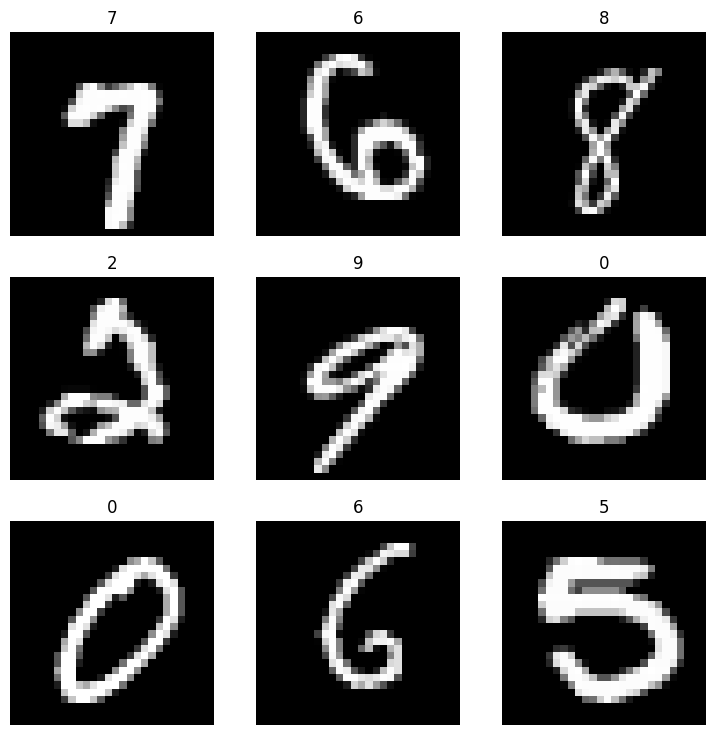

In [2]:

datablock: DataBlock = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name='testing')
)
dls = datablock.dataloaders(path, bs=256)
dls.show_batch()

/home/manu/prog/content/safetensors-vs-cpkt/venv/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/manu/prog/content/safetensors-vs-cpkt/venv/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/home/manu/prog/content/safetensors-vs-cpkt/venv/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

SuggestedLRs(minimum=0.05248074531555176, steep=0.013182567432522774, valley=0.0012022644514217973)

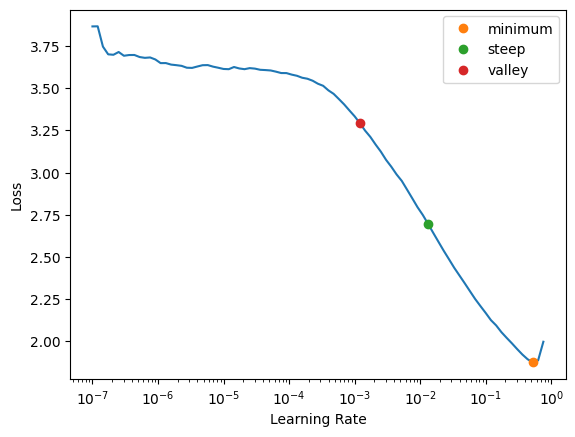

In [3]:
from torchvision.models import resnet34
from fastai.vision.learner import vision_learner

from fastai.callback.schedule import minimum, steep, valley

learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
suggest_lr = learn.lr_find(suggest_funcs=(minimum, steep, valley))
suggest_lr

In [4]:

learn.fine_tune(7, base_lr=abs(suggest_lr.steep - suggest_lr.valley)/2)

epoch,train_loss,valid_loss,error_rate,time
0,0.627497,0.332881,0.104300,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.087894,0.067604,0.021300,00:34
1,0.059028,0.050919,0.016300,00:29
2,0.038305,0.039938,0.010600,00:27
3,0.029441,0.034518,0.009400,00:28
4,0.013995,0.026372,0.007100,00:37
5,0.005372,0.024915,0.006200,00:38
6,0.003027,0.024741,0.006600,00:34


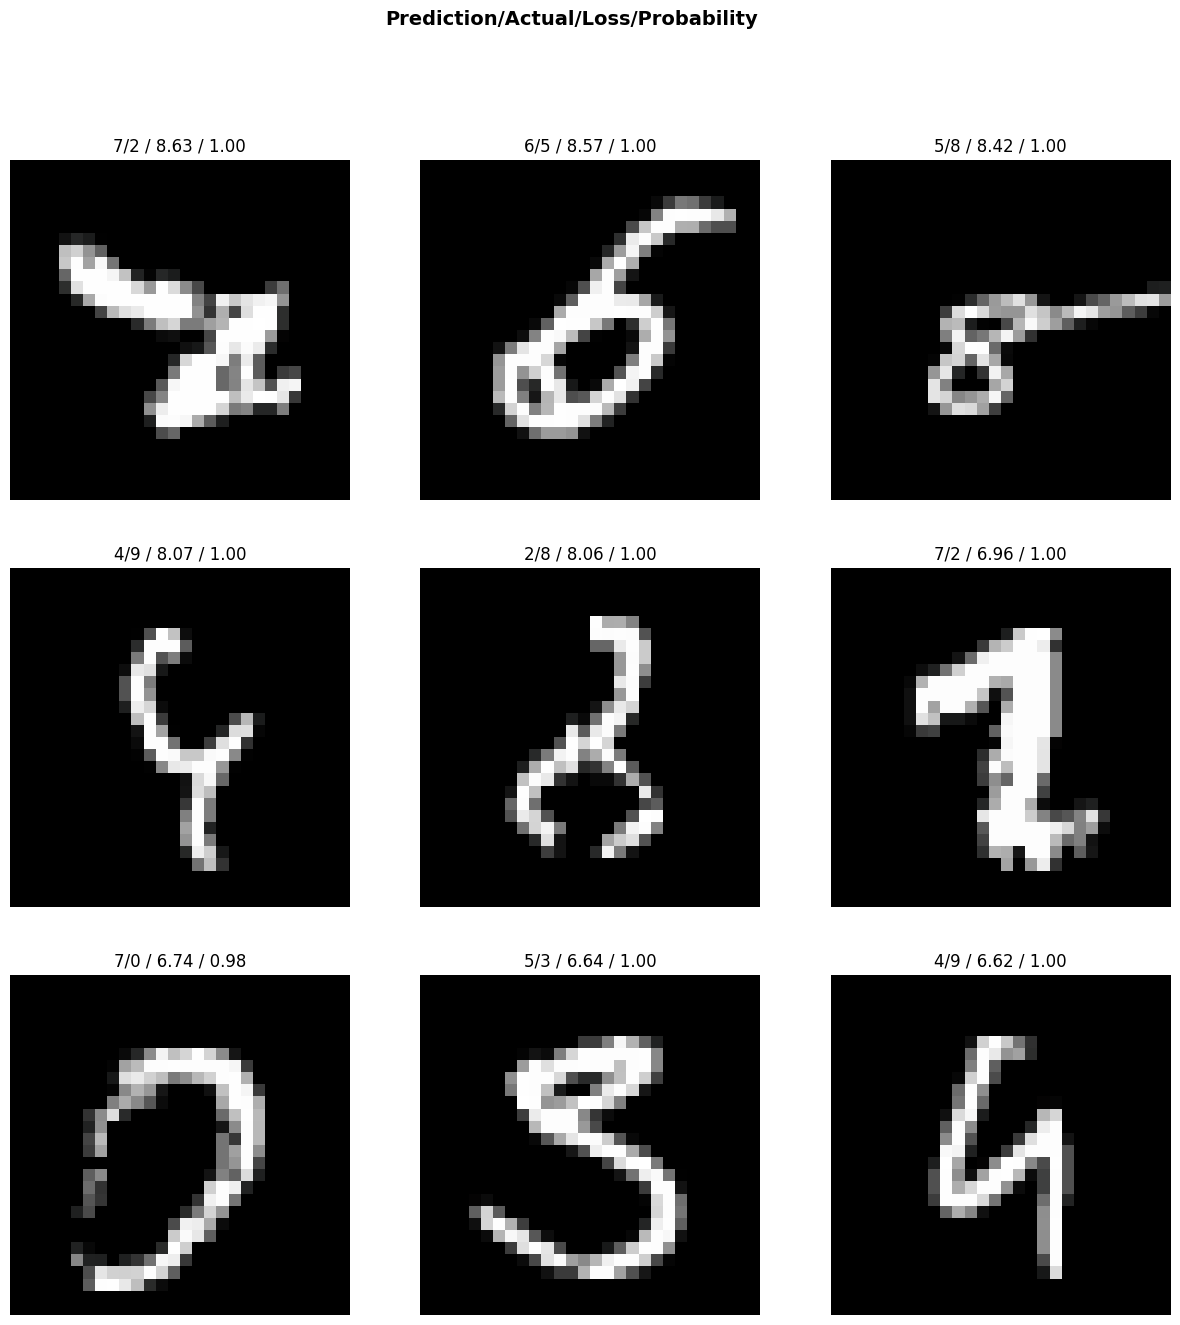

In [5]:
from fastai.interpret import Interpretation

interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,15))

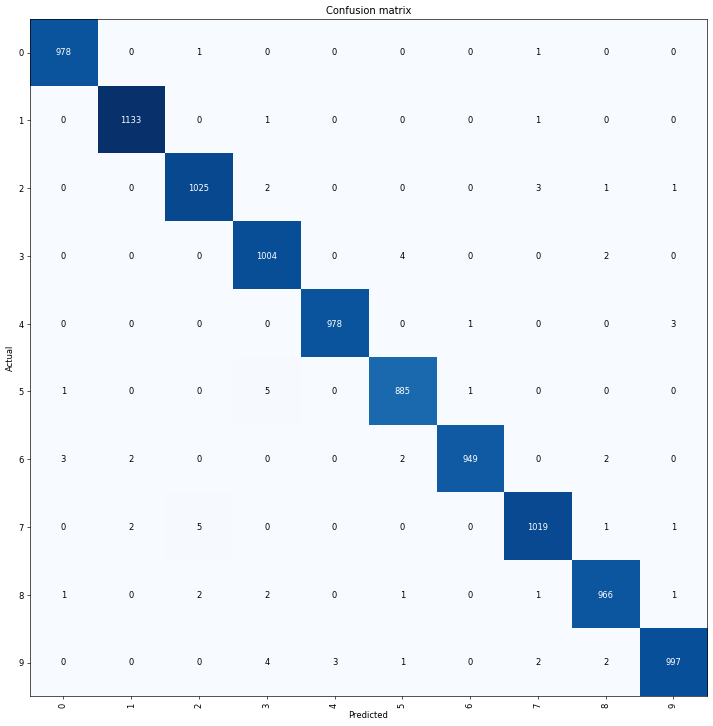

In [6]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [7]:
import torch

learn.export()
torch.save(learn.state_dict(), 'state.pth')

In [8]:
from safetensors.torch import save_model

save_model(learn.model, 'digits.safetensors')